Описание данных:

В данной лабораторной работе представлены данные по диабету среди коренных жительниц США. В данном датасете представлены следующие признаки:


1.   Количестов беременностей
2.   Глюкоза
3.   Кровяное давление
4.   Толщина кожи
5.   Инсулин
6.   BMI
7.   Diabetes Pedigree Function
8.   Возраст
9.   Исход

Все признаки, кроме исхода, являются вещественными, а исход является бинарным признаком, где 1 - больной, а 0 - здоровый пациент.

Выполнение работы:

Сначала подключаемся к облачному хранилищу для работы с файлом и подключаем все необходимые библиотеки.

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
plt.style.use('ggplot')
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rc, plot
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, roc_curve, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import itertools
from collections import defaultdict
np.random.seed(5)

DiabetSet = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/diabetes (1).csv")
DiabetSet.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Изменим тип данных для больных с числового формата на категориальный, а также создадим функцию для вывода матрицы ошибок

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Создадим функцию для вывода необходимых метрик

In [ ]:
def some_metrics(y_test, X_pred):
    accuracy = accuracy_score(y_test, X_pred)
    precision = precision_score(y_test, X_pred)
    recall = recall_score(y_test, X_pred)
    f1 = f1_score(y_test, X_pred)
    roc_auc = roc_auc_score(y_test, X_pred)
    return [accuracy, precision, recall, f1, roc_auc]
     


In [ ]:
DiabetSet = DiabetSet.astype({'Outcome': 'category'})

Рассмотрим показатели, которые входят в данный дата-сет. Имеются 1 качественная переменная - Outcome, остальные 8 - Pregnancies, Glucose, BloodPressure,	SkinThickness,	Insulin, BMI, DiabetesPedigreeFunction, Age - количественные

In [ ]:
DiabetSet.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

Далее с помощью методы dtype определяем типы данных, которые представлены в данной таблице. В данном случае типы данных это int64 и float64


In [ ]:
DiabetSet.dtypes

Pregnancies                    int64
Glucose                        int64
BloodPressure                  int64
SkinThickness                  int64
Insulin                        int64
BMI                          float64
DiabetesPedigreeFunction     float64
Age                            int64
Outcome                     category
dtype: object

Для более коректного сравнения произведем замену нулевых значений на среднее, на основании предыдущей группировки по исходу, данная замена позволит более четко проследить зависимость и впоследствии построить какую-либо модель.

In [ ]:
Indexes = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
for line in range(len(DiabetSet)):
  for col in range(1, len(DiabetSet.loc[line])-1):
    if DiabetSet.loc[line, Indexes[col]] == 0:
      DiabetSet.loc[line, Indexes[col]] = DiabetSet.groupby(['Outcome']).mean().loc[DiabetSet.loc[line, 'Outcome'], Indexes[col]]
DiabetSet.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,100.335821,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,68.792000,26.6,0.351,31,0
2,8,183.0,64.0,22.164179,100.710208,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


Проверим корректность заполнения пропусков с помощью функции count.

In [ ]:
DiabetSet.count(axis=0)

Pregnancies                 768
Glucose                     768
BloodPressure               768
SkinThickness               768
Insulin                     768
BMI                         768
DiabetesPedigreeFunction    768
Age                         768
Outcome                     768
dtype: int64

Факт заболевания уже приведен к векторному значению [1,0] где:

1 - Человек болен диабетом

0 - Человек здоров

In [ ]:
DiabetSet['Outcome'].unique()

[1, 0]
Categories (2, int64): [0, 1]

Разделим данный дата сет на 2 разных списка:

1) В первый группу войдуют все столбцы с вещественными перемеными

2) Во вторую группу войдут категориальные перменные (В нашем случае факт заболевания)

In [ ]:
categorical_columns = [c for c in DiabetSet.columns if DiabetSet[c].dtype.name == 'category']
numerical_columns   = [c for c in DiabetSet.columns if DiabetSet[c].dtype.name != 'category']
print(categorical_columns)
print(numerical_columns)

['Outcome']
['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


Построим таблицу корреляции между количественными признаками чтобы определить наличие каких-либо взаимосвязей между элементами.
Как видно из данной таблицы, значимая корреляция присутсвует между показателями SkinThickness/Insulin и SkinThickness/BMI.

In [ ]:
DiabetSet.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Pregnancies,1.000000,0.129888,0.208932,0.043491,0.024033,0.024206,-0.033523,0.544341
Glucose,0.129888,1.000000,0.224223,0.201485,0.457924,0.235649,0.138169,0.268599
BloodPressure,0.208932,0.224223,1.000000,0.159172,0.042504,0.285186,-0.001377,0.325992
SkinThickness,0.043491,0.201485,0.159172,1.000000,0.225708,0.557636,0.132475,0.069591
Insulin,0.024033,0.457924,0.042504,0.225708,1.000000,0.222288,0.150209,0.089379
BMI,0.024206,0.235649,0.285186,0.557636,0.222288,1.000000,0.152590,0.027932
DiabetesPedigreeFunction,-0.033523,0.138169,-0.001377,0.132475,0.150209,0.152590,1.000000,0.033561
Age,0.544341,0.268599,0.325992,0.069591,0.089379,0.027932,0.033561,1.000000


Проведем нормализацию показателей для применения методов опорных векторов и метод ближайших соседей, которык чувствительны к масштабированию данных. Для этого вычтем из значений их среднее и поделим на стандартное отклонение.

In [ ]:
data_numerical = DiabetSet[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean()) / data_numerical.std()
data_numerical.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-7.864080e-17,-3.376928e-16,2.035409e-16,-5.088522e-17,2.035409e-16,-2.289835e-16,2.451743e-16,2.035409e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.141108e+00,-2.550568e+00,-3.992657e+00,-2.238573e+00,-1.282577e+00,-2.070184e+00,-1.188778e+00,-1.040871e+00
25%,-8.443348e-01,-7.203752e-01,-6.888829e-01,-6.112570e-01,-5.365841e-01,-7.183811e-01,-6.885198e-01,-7.857741e-01
50%,-2.507887e-01,-1.540824e-01,-2.812799e-02,-1.773060e-01,-2.790675e-01,-5.701520e-02,-2.999328e-01,-3.606124e-01
75%,6.395305e-01,6.338033e-01,6.326269e-01,4.736206e-01,1.823267e-01,6.043507e-01,4.659233e-01,6.597757e-01
max,3.904034e+00,2.537860e+00,4.101590e+00,7.742300e+00,7.892365e+00,5.037682e+00,5.879733e+00,4.061069e+00


Создадим новую таблицу, в которой объединим нормальзированные данные с категориальными.

In [ ]:
data = pd.concat((data_numerical, DiabetSet[categorical_columns]), axis=1)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.639530,0.863603,-0.028128,0.799084,-0.330502,0.168285,0.468187,1.425067,1
1,-0.844335,-1.204597,-0.523694,0.148157,-0.678354,-0.849201,-0.364823,-0.190548,0
2,1.233077,2.012603,-0.688883,-0.593446,-0.326374,-1.328873,0.604004,-0.105515,1
3,-0.844335,-1.073282,-0.523694,-0.502769,-0.400371,-0.631168,-0.920163,-1.040871,0
4,-1.141108,0.502489,-2.671148,0.799084,0.415670,1.549159,5.481337,-0.020483,1
...,...,...,...,...,...,...,...,...,...
763,1.826623,-0.679339,0.302249,2.209425,0.548001,0.066537,-0.908090,2.530487,0
764,-0.547562,0.010060,-0.193317,-0.068818,-0.226184,0.633422,-0.398023,-0.530677,0
765,0.342757,-0.022768,-0.028128,-0.502769,-0.201875,-0.907343,-0.684747,-0.275580,0
766,-0.844335,0.141375,-1.019260,0.326722,0.406064,-0.340458,-0.370859,1.169970,1


Для удобства выделим матрицу объект-признак обозначим ее через Х, а результативный признак обозначим как у

In [ ]:
X = data.drop(('Outcome'), axis=1)
y = data['Outcome']
feature_names = X.columns

Разобьем имеющиеся у нас данные на обучающую и тестовую выборки, для этого воспользуемся функцией train_test_split из модуля sklearn.model_selection и разобьем данные на обучающую/тестовую выборки в отношении 70%:30%

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

537 231


In [ ]:
result= defaultdict(str)

После выполнения основных манипуляций с данными и разбиением выборки на тренировочную и тестовую, перейдем непосредственно к процессу обучения.

Начнем с метода Knn или метода К ближайших соседей.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform')

KNeighborsClassifier()

Accuracy: 0.7532467532467533
Precision: 0.6582278481012658
Recall 0.6341463414634146
F1: 0.6459627329192545
ROC_AUC: 0.7264691438860698
Confusion matrix, without normalization
[[122  27]
 [ 30  52]]


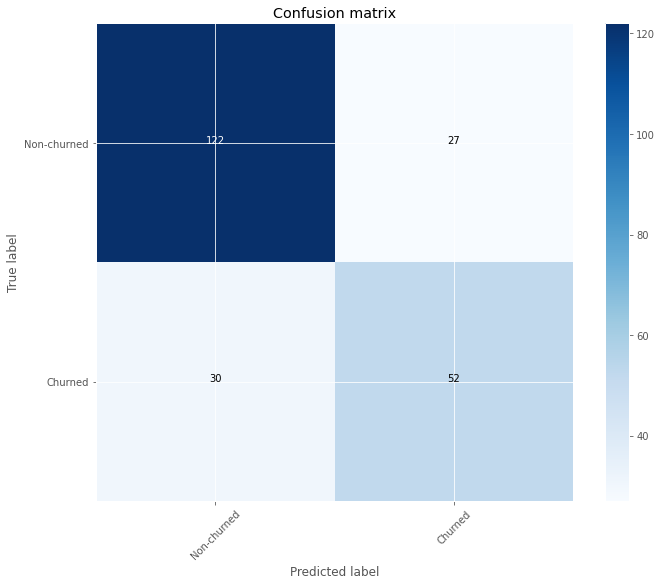

In [ ]:
y_train_predict = knn.predict(X_train)
y_test_predict = knn.predict(X_test)

cnf_matrix = confusion_matrix(y_test, knn.predict(X_test))

metric = some_metrics(y_test, knn.predict(X_test))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
result['knn'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

В данном случае Accuracy составила 75,36%. Precision и Recall составили 65,82% и 63,41% соотвественно, F1 составила 64,59% а площадь под кривой 72,64%. В целом не самые лучшие показатели, в связи с этим попробуем откалибровать модель путем перебора разных k среди значений [1, 3, 5, 7, 10, 15, 20, 30, 40]

In [ ]:
n_neighbors_array = [1, 3, 5, 7, 10, 15, 20, 30, 40]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid={'n_neighbors': n_neighbors_array})
grid.fit(X_train, y_train)

best_cv_err = grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.7653340256143994 40


Данный метод нашел оптимальные значения k, равное 40, при этом ошибка при кросс проверке составила 76,53%, что ниже чем на тренировочной выборке

Accuracy: 0.7965367965367965
Precision: 0.7966101694915254
Recall 0.573170731707317
F1: 0.6666666666666666
ROC_AUC: 0.7463169094778197
Confusion matrix, without normalization
[[137  12]
 [ 35  47]]


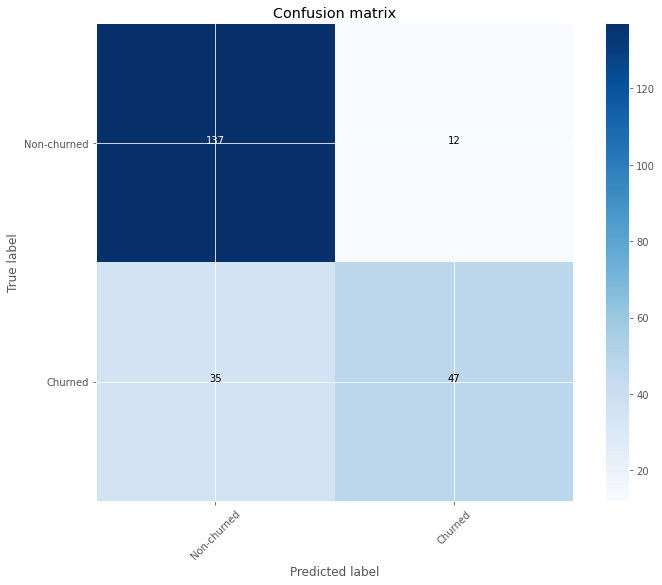

In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)

cnf_matrix = confusion_matrix(y_test, knn.predict(X_test))

metric = some_metrics(y_test, knn.predict(X_test))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
result['knn'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

После подбора оптимального значения k показатели немного улучшились. Так доля правильных ответов составила 79,65%, а точность и полнота соответственно 79,66% и 57,31%. F-мера составила 66,66%, а ROC_AUC 74.63%.

В целом примение метода k ближайших соседей не дало удовлетворительных результатов на данном дата сете, по этому прибегнем к иным методикам.

Accuracy: 0.8181818181818182
Precision: 0.8125
Recall 0.6341463414634146
F1: 0.7123287671232876
ROC_AUC: 0.7768047143558684
Confusion matrix, without normalization
[[137  12]
 [ 30  52]]


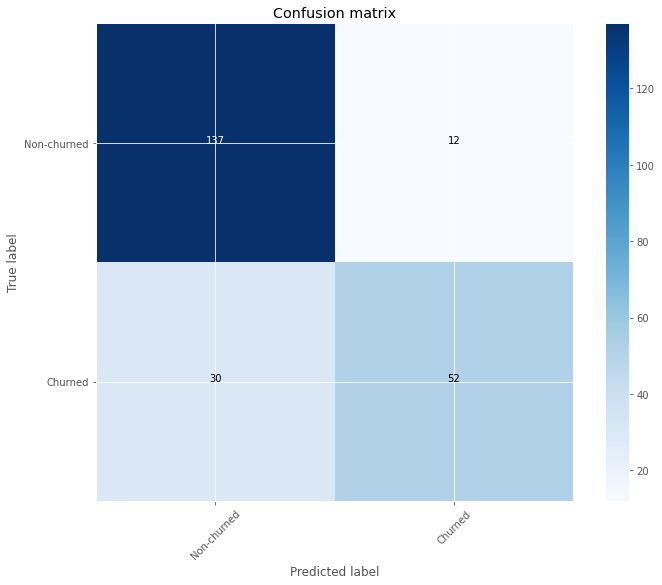

In [ ]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train, y_train)

cnf_matrix = confusion_matrix(y_test, svc.predict(X_test))

metric = some_metrics(y_test, svc.predict(X_test))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
result['svc'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

In [ ]:
print(y_train, y_train.dtype)

409    1
63     0
61     1
405    0
747    0
      ..
269    1
337    1
91     0
80     0
703    0
Name: Outcome, Length: 537, dtype: category
Categories (2, int64): [0, 1] category


Воспользуемся методом опорных векторов. Данный метод выдает показатели лучше, чем на предыдущем методе. Так ошибка составила 81,81%, точность и полнотоа в свою очередь по 81,25% и 63,41%. F-мера 71,23%, ROC_AUC 77,68%. Данные результаты более удовлетворительные, чем на предыдущем методе, но попробуем рассчитать разные ядра для данного метода.

 Попробуем откалибровать модель путем применения разных ядер для данного метода.

***Радиальное ядро***

In [ ]:
C_array = np.logspace(-3, 3, num=7)
gamma_array = np.logspace(-5, 2, num=8)
svc = SVC(kernel='rbf')
grid = GridSearchCV(svc, param_grid={'C': C_array, 'gamma': gamma_array})
grid.fit(X_train, y_train)
print('CV error    = ', 1 - grid.best_score_)
print('best C      = ', grid.best_estimator_.C)
print('best gamma  = ', grid.best_estimator_.gamma)

CV error    =  0.2085496711664937
best C      =  100.0
best gamma  =  0.01


Accuracy: 0.8181818181818182
Precision: 0.7777777777777778
Recall 0.6829268292682927
F1: 0.7272727272727273
ROC_AUC: 0.7877721394663613
Confusion matrix, without normalization
[[133  16]
 [ 26  56]]


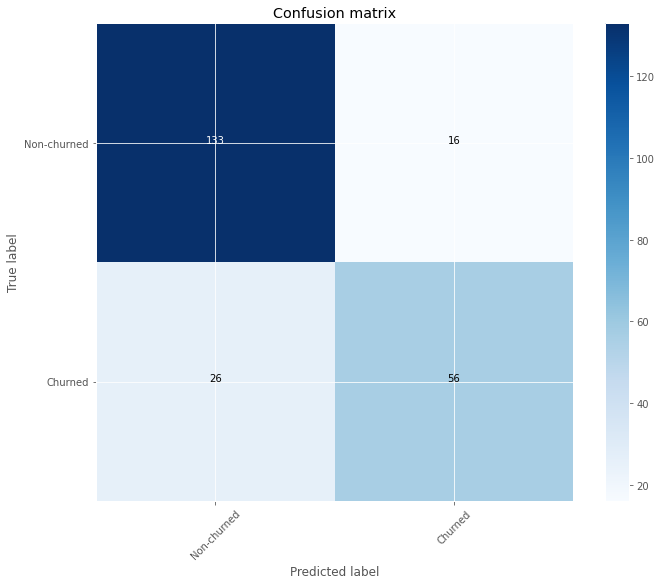

In [ ]:
svc = SVC(kernel='rbf', C=grid.best_estimator_.C, gamma=grid.best_estimator_.gamma)
svc.fit(X_train, y_train)

cnf_matrix = confusion_matrix(y_test, svc.predict(X_test))

metric = some_metrics(y_test, svc.predict(X_test))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
result['svcRad'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

При использовании радиального ядра наблюдается незначительное улучшение ряда метрик, при этом точность ухудшается

***Линейное ядро***

In [ ]:
C_array = np.logspace(-3, 3, num=7)
svc = SVC(kernel='linear')
grid = GridSearchCV(svc, param_grid={'C': C_array})
grid.fit(X_train, y_train)
print('CV error    = ', 1 - grid.best_score_)
print('best C      = ', grid.best_estimator_.C)

CV error    =  0.23283142956040148
best C      =  0.01


Accuracy: 0.7662337662337663
Precision: 0.7916666666666666
Recall 0.4634146341463415
F1: 0.5846153846153846
ROC_AUC: 0.6981502700933049
Confusion matrix, without normalization
[[139  10]
 [ 44  38]]


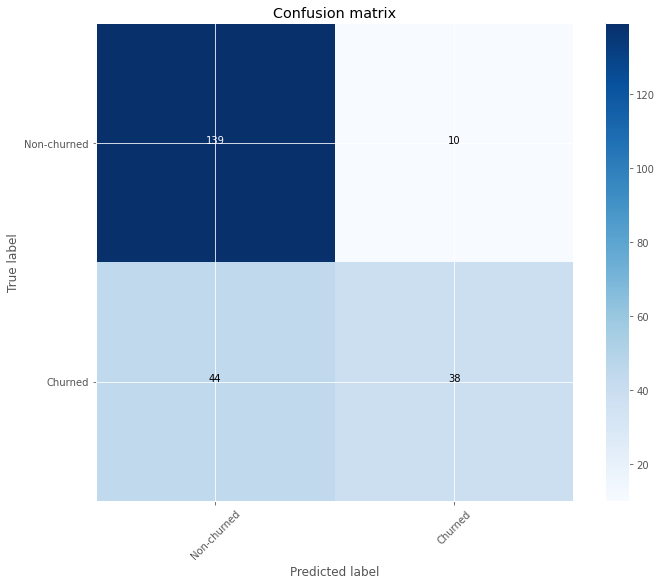

In [ ]:
svc = SVC(kernel='linear', C=grid.best_estimator_.C)
svc.fit(X_train, y_train)

cnf_matrix = confusion_matrix(y_test, svc.predict(X_test))

metric = some_metrics(y_test, svc.predict(X_test))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
result['svcLin'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

Линейное ядро показало ухудшение по всем показателям, в связи с чем в рассчет его брать не будем

Перейдем к заключительному методу случайного леса, который строит ансамбль случайных деревьев, каждое из которых обучается на выборке, полученной из исходной с помощью процедуры изъятия с возвращением

Accuracy: 0.8441558441558441
Precision: 0.8108108108108109
Recall 0.7317073170731707
F1: 0.7692307692307694
ROC_AUC: 0.8188737927647733
Confusion matrix, without normalization
[[135  14]
 [ 22  60]]


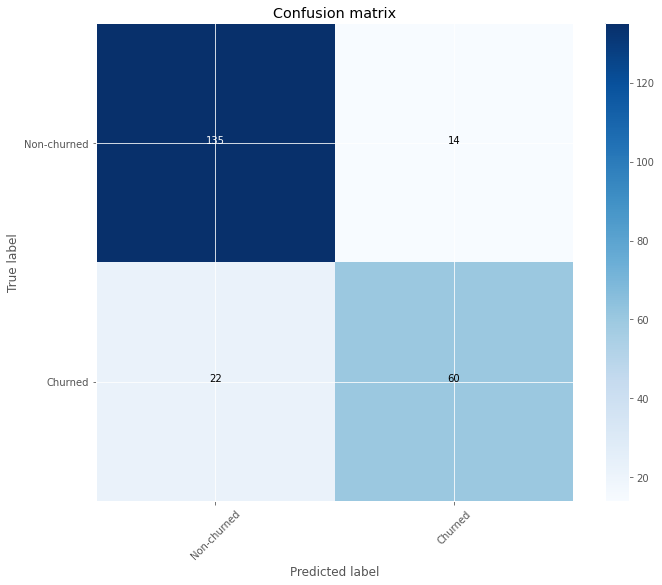

In [ ]:
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train, y_train)

cnf_matrix = confusion_matrix(y_test, rf.predict(X_test))

metric = some_metrics(y_test, rf.predict(X_test))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
result['rf'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

Данный метод выдает наилучшие показатели среди всех методов. Так доля правильных ответов составила 84,41%, точность и полнотоа в свою очередь по 81,08% и 73,17%. F-мера 76,92%, ROC_AUC 81,88%. Рассмотрим, какая из переменных вносит наибольший вклад в вероятность диабета

In [ ]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:24s}' ({:.4f})".format(f + 1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'Insulin                 ' (0.3109)
 2. feature 'Glucose                 ' (0.1753)
 3. feature 'SkinThickness           ' (0.1060)
 4. feature 'BMI                     ' (0.1045)
 5. feature 'Age                     ' (0.0971)
 6. feature 'DiabetesPedigreeFunction' (0.0879)
 7. feature 'Pregnancies             ' (0.0602)
 8. feature 'BloodPressure           ' (0.0581)


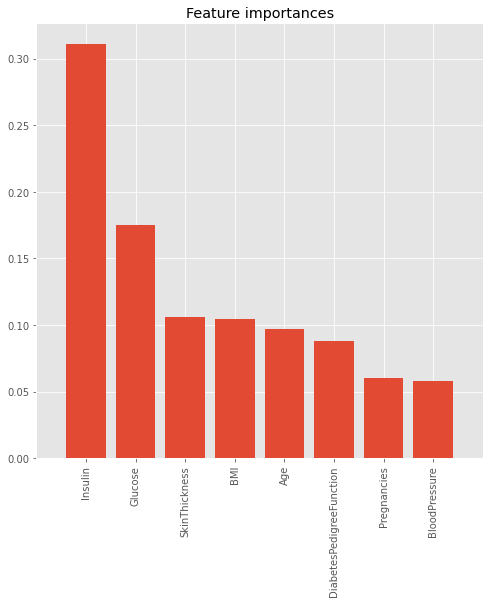

In [ ]:
d_first = 8
plt.figure(figsize=(8, 8))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

Как видно из графика выше, наибольшую влияние оказывает инсулин и глюкоза, что вполне логично, а вот то что на третьем месте толщина кожи, является неожиданным. При этом наименьшее влияние оказало крвояное давление и количество беременностей.

In [ ]:
best_features = indices[:8]
best_features_names = feature_names[best_features]
print(best_features_names)

Index(['Insulin', 'Glucose', 'SkinThickness', 'BMI', 'Age',
       'DiabetesPedigreeFunction', 'Pregnancies', 'BloodPressure'],
      dtype='object')


In [ ]:
for label in result:
  print(f'{label.ljust(6)} Accuracy: {round(result[label][0], 4)} Precision: {round(result[label][1], 4)} Recall {round(result[label][2], 4)} F1: {round(result[label][3], 4)} ROC_AUC: {round(result[label][4], 4)}')

knn    Accuracy: 0.7965 Precision: 0.7966 Recall 0.5732 F1: 0.6667 ROC_AUC: 0.7463
svc    Accuracy: 0.8182 Precision: 0.8125 Recall 0.6341 F1: 0.7123 ROC_AUC: 0.7768
svcRad Accuracy: 0.8182 Precision: 0.7778 Recall 0.6829 F1: 0.7273 ROC_AUC: 0.7878
svcLin Accuracy: 0.7662 Precision: 0.7917 Recall 0.4634 F1: 0.5846 ROC_AUC: 0.6982
rf     Accuracy: 0.8442 Precision: 0.8108 Recall 0.7317 F1: 0.7692 ROC_AUC: 0.8189


Как отмечалось выше, наилучшие показатели в большинстве случаев были достигнуты при применении метода слукчайного леса.

Проведем сэмплирование тремя разными способами и посмотрим, приведет ли это к какому-либо положительному результату или нет. Применим все методы сэмплирования к методу rf.

In [ ]:
SamplingResults = defaultdict(str)

NameError: ignored

***Random Undersampling***

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
data_under = RandomUnderSampler()
X_under, y_under = data_under.fit_resample(X, y)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split (X_under,
y_under, test_size=0.3, random_state = 11)


Accuracy: 0.8198757763975155
Precision: 0.813953488372093
Recall 0.8433734939759037
F1: 0.8284023668639053
ROC_AUC: 0.8191226444238493
Confusion matrix, without normalization
[[62 16]
 [13 70]]


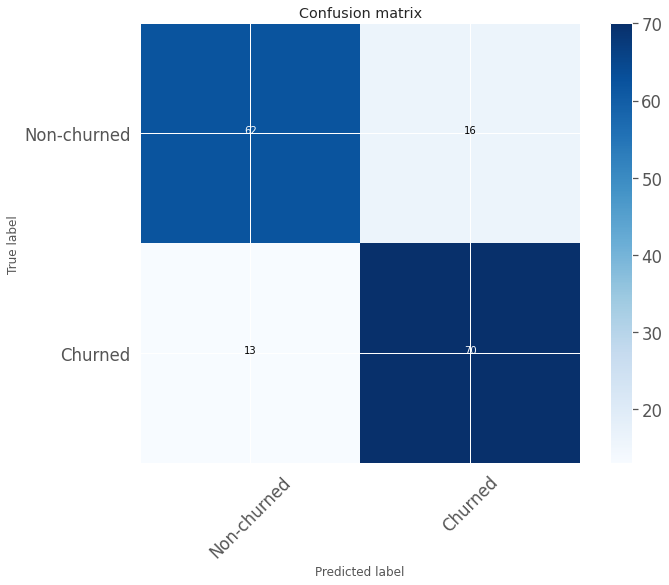

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train_under, y_train_under)

cnf_matrix = confusion_matrix(y_test_under, rf.predict(X_test_under))

metric = some_metrics(y_test_under, rf.predict(X_test_under))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
SamplingResults['RfUnder'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

***Random Oversampling***

In [ ]:
from imblearn.over_sampling import RandomOverSampler
data_over = RandomOverSampler()
X_over, y_over = data_over.fit_resample(X, y)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split (X_over,
y_over, test_size=0.3, random_state = 11)

Accuracy: 0.9033333333333333
Precision: 0.8733333333333333
Recall 0.9290780141843972
F1: 0.9003436426116839
ROC_AUC: 0.9047905794192427
Confusion matrix, without normalization
[[140  19]
 [ 10 131]]


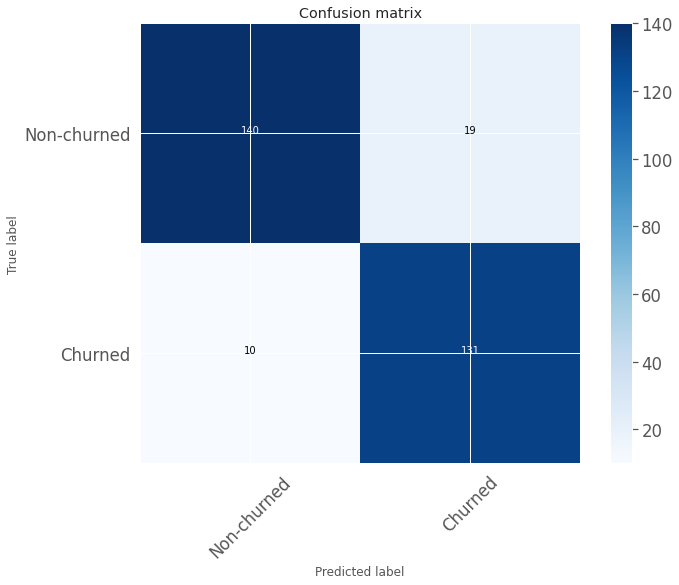

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train_over, y_train_over)

cnf_matrix = confusion_matrix(y_test_over, rf.predict(X_test_over))

metric = some_metrics(y_test_over, rf.predict(X_test_over))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
SamplingResults['RfOver'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

***Synthetic Minority Oversampling Technique***

In [ ]:
from imblearn.over_sampling import SMOTE
data_smote = SMOTE()
X_sm, y_sm = data_smote.fit_resample(X, y)
X_train_sm, X_test_sm, y_train_sm, y_test_sm= train_test_split(X_sm, y_sm,
test_size=0.3, random_state = 11)

Accuracy: 0.88
Precision: 0.8620689655172413
Recall 0.8865248226950354
F1: 0.8741258741258741
ROC_AUC: 0.8803693295865114
Confusion matrix, without normalization
[[139  20]
 [ 16 125]]


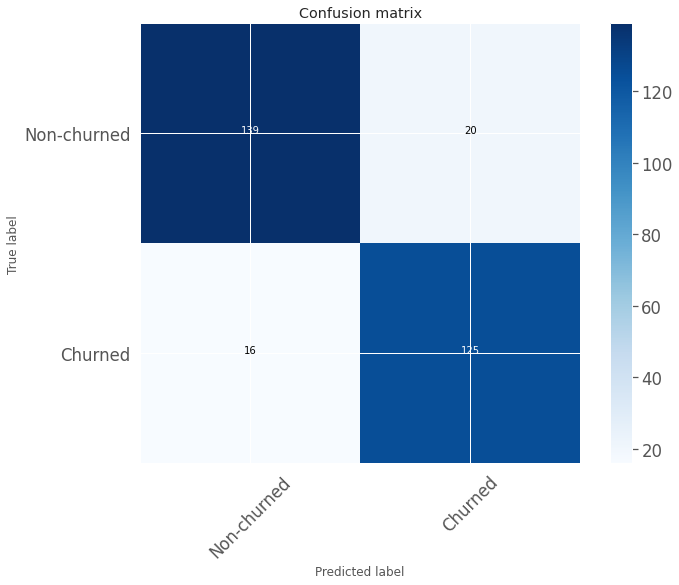

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train_sm, y_train_sm)

cnf_matrix = confusion_matrix(y_test_sm, rf.predict(X_test_sm))

metric = some_metrics(y_test_sm, rf.predict(X_test_sm))
print(f"Accuracy: {metric[0]}\nPrecision: {metric[1]}\nRecall {metric[2]}\nF1: {metric[3]}\nROC_AUC: {metric[4]}")
SamplingResults['RfSm'] = metric

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'], title='Confusion matrix')
plt.show()

In [ ]:
print(f'{"rf".ljust(7)} Accuracy: {round(result["rf"][0], 2)} Precision: {round(result["rf"][1], 2)} Recall {round(result["rf"][2], 2)} F1: {round(result["rf"][3], 2)} ROC_AUC: {round(result["rf"][4], 2)}')
for label in SamplingResults:
  print(f'{label.ljust(7)} Accuracy: {round(SamplingResults[label][0], 2)} Precision: {round(SamplingResults[label][1], 2)} Recall {round(SamplingResults[label][2], 2)} F1: {round(SamplingResults[label][3], 2)} ROC_AUC: {round(SamplingResults[label][4], 2)}')

rf      Accuracy: 0.84 Precision: 0.81 Recall 0.73 F1: 0.77 ROC_AUC: 0.82
RfUnder Accuracy: 0.82 Precision: 0.81 Recall 0.84 F1: 0.83 ROC_AUC: 0.82
RfOver  Accuracy: 0.9 Precision: 0.87 Recall 0.93 F1: 0.9 ROC_AUC: 0.9
RfSm    Accuracy: 0.88 Precision: 0.86 Recall 0.89 F1: 0.87 ROC_AUC: 0.88


По результатам сэмплирования наилучший показатели были получены после проведения Random Oversampling, по результам которого почти все показатели достигли 0,9.

